<h2 style='color:Blue'> Asset Management - Assignment T4</h2>

Group 42
- 55944 Ines Dewever
- 54616 Jannis Schmidt
- 55584 Leon Kahrig
- 56025 Meeka Lenisa

First, we import the necessary packages and load our data. We acquired book-to-market and stock data for 50 stocks from the WRDS database.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import openpyxl

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Q3
from scipy.stats import skew, kurtosis

In [2]:
stock_prices = pd.read_csv('stock_prices.csv')
book_to_market = pd.read_csv('book_to_market.csv')

book_to_market = book_to_market.drop(['permno', 'adate', 'qdate'], axis = 1)
book_to_market = book_to_market.rename(columns = {'bm' : 'book_to_market', 'public_date' : 'date', 'TICKER' : 'tic'})
book_to_market['date'] =  pd.to_datetime(book_to_market['date'], format='%Y-%m-%d')
book_to_market['date'] = book_to_market['date'].dt.to_period('M')

stock_prices = stock_prices.drop(['gvkey', 'iid', 'navm', 'cmth', 'cyear', 'exchg', 'conm'], axis = 1)
stock_prices = stock_prices.rename(columns = {'datadate' : 'date', 'prccm' : 'price_close', 'prchm' : 'price_high', 'prclm' : 'price_low'})
stock_prices['date'] =  pd.to_datetime(stock_prices['date'], format='%Y-%m-%d')
stock_prices['date'] = stock_prices['date'].dt.to_period('M')

df_tic = pd.merge(book_to_market, stock_prices, how = 'left', on = ['tic', 'date'])
df_tic = df_tic[['date', 'tic', 'book_to_market', 'price_close', 'price_high', 'price_low']]
df_tic = df_tic.set_index('date')

#Filter relevant stocks for Group 42
df_tickers = pd.read_excel("Tickers_T4.xlsx", usecols=["Group 42"])
tickers = df_tickers['Group 42'].tolist()
df_tic = df_tic[df_tic['tic'].isin(tickers)]

# Convert index to datetime64 type
df_tic.index = df_tic.index.to_timestamp()

# Drop rows with missing data
df_tic.dropna(subset=['book_to_market', 'price_close'], inplace=True)

display(df_tic)
df_tic.info()

,tic,book_to_market,price_close,price_high,price_low
date,,,,,
1987-11-01,FAST,0.204,12.750,13.250,12.2500
1987-12-01,FAST,0.204,14.750,14.750,12.2500
1988-01-01,FAST,0.204,16.250,16.250,14.2500
1988-02-01,FAST,0.215,16.750,17.250,15.7500
1988-03-01,FAST,0.215,15.625,17.500,15.2500
...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100
2022-09-01,FTNT,0.014,49.130,55.940,47.3700
2022-10-01,FTNT,0.014,57.160,57.335,45.7400


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15876 entries, 1987-11-01 to 2022-12-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tic             15876 non-null  object 
 1   book_to_market  15876 non-null  float64
 2   price_close     15876 non-null  float64
 3   price_high      15876 non-null  float64
 4   price_low       15876 non-null  float64
dtypes: float64(4), object(1)
memory usage: 744.2+ KB


In our analysis of stock portfolios, we encountered instances of missing values for the book-to-market ratio and stock prices, particularly in the early years of the dataset. To maintain the integrity and accuracy of our analysis, we have decided to remove the rows with missing book-to-market and price_close values which, in the majority of cases, was caused by the companies not existing since 1980. This approach allows us to avoid introducing any bias or inaccuracies that might arise from using arbitrary values to fill the missing data, while still preserving the robustness of our findings.

<h2 style='color:Blue'> 1. Annualized performance statistics for our stocks  </h2>

Present annualized performance statistics (average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown) for your stocks.

In [3]:
# Calculate the monthly returns
df_tic['monthly_returns'] = df_tic.groupby('tic')['price_close'].pct_change()

# Annualize the returns
df_tic['annual_returns'] = (1 + df_tic['monthly_returns']).pow(12) - 1

# Calculate the annualized statistics for each stock
stats_stocks = df_tic.groupby('tic')['annual_returns'].agg(
    mean_return=np.mean,
    volatility=np.std,
    skewness=lambda x: x.skew(),
    kurtosis=lambda x: x.kurt()
)

# Calculate the Sharpe ratio
risk_free_rate = 0.03  
stats_stocks['sharpe_ratio'] = (stats_stocks['mean_return'] - risk_free_rate) / stats_stocks['volatility']

# Calculate max drawdown
df_tic['cum_returns'] = (1 + df_tic['monthly_returns']).cumprod()
df_tic['cum_max'] = df_tic.groupby('tic')['cum_returns'].cummax()
df_tic['drawdown'] = df_tic['cum_returns'] / df_tic['cum_max'] - 1
stats_stocks['max_drawdown'] = df_tic.groupby('tic')['drawdown'].min()

display(stats_stocks)

,mean_return,volatility,skewness,kurtosis,sharpe_ratio,max_drawdown
tic,,,,,,
AAPL,2.297728e+00,7.169554e+00,6.303614,54.786690,0.316300,-0.895886
ABC,5.018085e-01,1.496811e+00,6.053705,60.606431,0.315209,-0.779216
ACGL,1.178885e-02,3.808532e-01,1.311179,1.751423,-0.047817,-0.047619
AIZ,6.344771e-01,3.212661e+00,12.748896,179.383051,0.188155,-0.700132
ALB,1.426862e+00,6.371059e+00,10.172180,128.192873,0.219251,-0.763909
ALL,5.475457e-01,1.759382e+00,5.683019,48.708618,0.294163,-0.825143
AMD,4.950775e+04,9.042982e+05,20.547437,436.756074,0.054747,-0.980343
AMZN,9.483440e+02,1.472053e+04,15.714893,246.971672,0.064421,-0.976048
AVY,6.218179e-01,1.709208e+00,4.192580,32.784915,0.346253,-0.723499


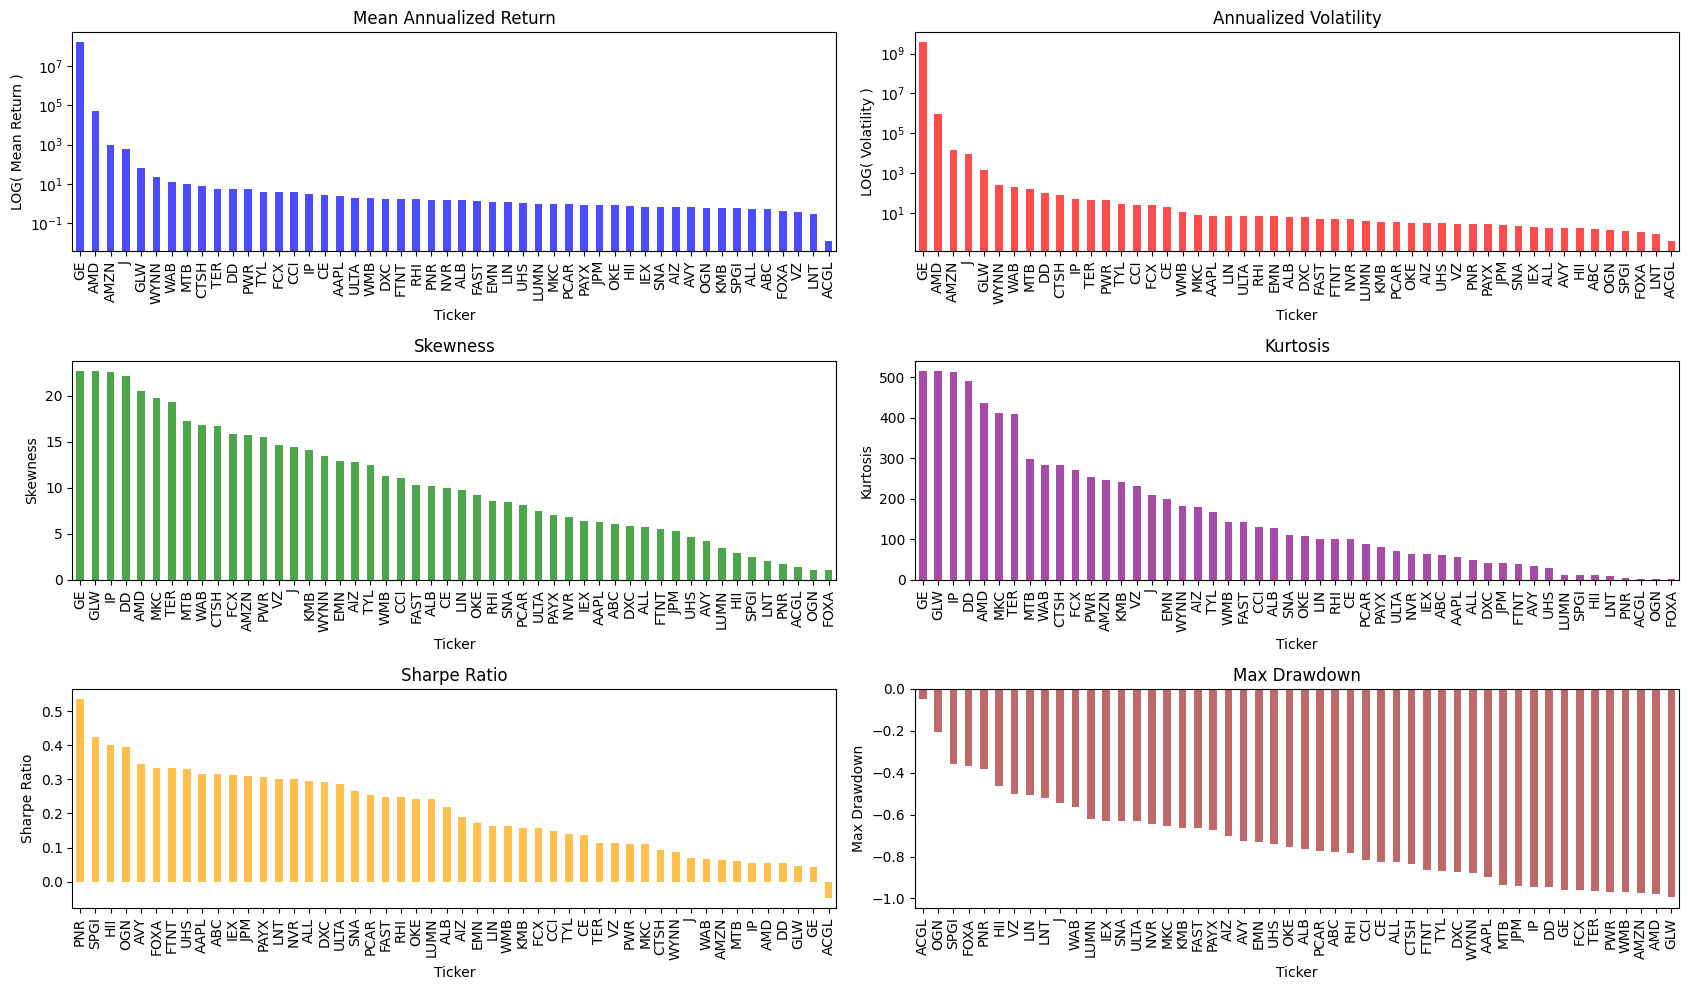

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(17, 10))

def plot_stat_subplot(ax, data, title, ylabel, color, logy=False):
    data.plot(kind='bar', ax=ax, color=color, alpha=0.7, logy=logy)
    ax.set_xlabel('Ticker')
    if logy == False:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('LOG( ' + ylabel + ' )')
    ax.set_title(title)

# Sort data by each statistic
stats_sorted = {
    stat: stats_stocks[stat].sort_values(ascending=False)
    for stat in ['mean_return', 'volatility', 'skewness', 'kurtosis', 'sharpe_ratio', 'max_drawdown']
}

# Mean Return
plot_stat_subplot(axes[0, 0], stats_sorted['mean_return'], 'Mean Annualized Return', 'Mean Return', 'blue', logy=True)
# Volatility
plot_stat_subplot(axes[0, 1], stats_sorted['volatility'], 'Annualized Volatility', 'Volatility', 'red', logy=True)
# Skewness
plot_stat_subplot(axes[1, 0], stats_sorted['skewness'], 'Skewness', 'Skewness', 'green')
# Kurtosis
plot_stat_subplot(axes[1, 1], stats_sorted['kurtosis'], 'Kurtosis', 'Kurtosis', 'purple')
# Sharpe Ratio
plot_stat_subplot(axes[2, 0], stats_sorted['sharpe_ratio'], 'Sharpe Ratio', 'Sharpe Ratio', 'orange')
# Max Drawdown
plot_stat_subplot(axes[2, 1], stats_sorted['max_drawdown'], 'Max Drawdown', 'Max Drawdown', 'brown')

plt.tight_layout()
plt.show()


***

<h2 style='color:Blue'> 2. Momentum indicator portfolios </h2>

Momentrum indicators are technical analysis tools used to determine the strength or weakness of a stock's price. Momentum measures the rate of the rise or fall of stock prices.

1. For each stock and each date, build a Momentum indicator which is defined as the cumulated return over the past six months. 

We drop the NaN values again to ensure the integrity of our performance statistics.

In [5]:
# Calculate the 6-month momentum for each stock
df_tic['momentum_6m'] = df_tic.groupby('tic')['price_close'].pct_change(periods=6)
# Drop rows with missing data for 6 month momentum to avoid errors in the computation of summary sataistics
df_tic.dropna(subset='momentum_6m', inplace=True)


2. Use the characteristics Book-to-Market and Momentum to build tercile portfolios, called:
- book-to-market :  Value_high, Value_med, Value_low 
- momentum  :  MoM_high,MoM_med, MoM_low 

    To construct the six portfolios, at each date and for each one of the two characteristic, split your 50 stocks in three equally weighted groups of similar sizes (example: for momentum in Jan 2000 you may have 16 stocks in the low Momentum group, 15 in the Middle group, 15 in the high Momentum group and 4 stocks with missing observations at this date). 

In [6]:
def create_equally_weighted_groups(x, num_groups=3):
    n = len(x)
    step = n // num_groups
    indices = np.argsort(x)
    terciles = np.empty_like(indices)
    terciles[indices[:step]] = 0
    terciles[indices[step:2 * step]] = 1
    terciles[indices[2 * step:]] = 2
    return terciles

# Create tercile portfolios based on Book-to-Market and Momentum
df_tic['bm_tercile'] = df_tic.groupby('date')['book_to_market'].transform(create_equally_weighted_groups)
df_tic['mom_tercile'] = df_tic.groupby('date')['momentum_6m'].transform(create_equally_weighted_groups)

# Assign portfolio names
bm_labels = ['Value_low', 'Value_med', 'Value_high']
mom_labels = ['MoM_low', 'MoM_med', 'MoM_high']

df_tic['bm_tercile'] = df_tic['bm_tercile'].map(dict(enumerate(bm_labels)))
df_tic['mom_tercile'] = df_tic['mom_tercile'].map(dict(enumerate(mom_labels)))


3. Present annualized performance statistics for the 6 portfolios.

In [7]:
def compute_summary_statistics(df_tic, portfolio_col, portfolio_names):
    def max_drawdown(returns):
        cum_returns = (1 + returns).cumprod()
        cum_max_return = cum_returns.cummax()
        drawdown = cum_returns / cum_max_return - 1
        return drawdown.min()

    # Compute the summary statistics for each month
    monthly_stats = df_tic.groupby(['date', portfolio_col])['annual_returns'].agg(
        mean_return=lambda x: np.mean(x),
        volatility=lambda x: np.std(x),
        skewness=lambda x: x.skew(),
        kurtosis=lambda x: x.kurt(),
        max_drawdown=lambda x: max_drawdown(x)
    )

    # Annualize mean_return and volatility
    monthly_stats['mean_return'] = (1 + monthly_stats['mean_return'])**12 - 1
    monthly_stats['volatility'] = monthly_stats['volatility'] * np.sqrt(12)

    # Compute the annualized Sharpe ratio
    risk_free_rate_annual = (1 + risk_free_rate)**12 - 1
    epsilon = 1e-8
    monthly_stats['sharpe_ratio'] = (monthly_stats['mean_return'] - risk_free_rate_annual) / (monthly_stats['volatility'] + epsilon)

    # Average the statistics for each portfolio
    portfolio_stats = monthly_stats.groupby([portfolio_col]).mean()

    # Filter the desired portfolios
    portfolio_stats = portfolio_stats.reset_index()
    filtered_stats = portfolio_stats[
        (portfolio_stats[portfolio_col].isin(portfolio_names))
    ]

    # Assign the specified index labels
    filtered_stats = filtered_stats.set_index(portfolio_col)

    # Select the required columns
    selected_stats = filtered_stats[['mean_return', 'volatility', 'sharpe_ratio', 'skewness', 'kurtosis', 'max_drawdown']]

    return selected_stats

# STATS BM PORTFOLIOS
portfolio_col = 'bm_tercile'
portfolio_names = ['Value_high', 'Value_med', 'Value_low']
bm_stats = compute_summary_statistics(df_tic, portfolio_col, portfolio_names)

# STATS BM PORTFOLIOS
portfolio_col = 'mom_tercile'
portfolio_names = ['MoM_high', 'MoM_med', 'MoM_low']
mom_stats = compute_summary_statistics(df_tic, portfolio_col, portfolio_names)

stats_bm_mom = pd.concat([bm_stats, mom_stats], axis=0)
display(stats_bm_mom)


,mean_return,volatility,sharpe_ratio,skewness,kurtosis,max_drawdown
Value_high,2.518704e+44,2.854615e+02,2.303501e+39,1.481056,3.014009,-0.692652
Value_low,2.504034e+71,4.461540e+04,1.392971e+64,1.406990,2.751811,-0.696178
Value_med,2.029874e+114,1.433302e+08,2.776907e+103,1.306502,2.473458,-0.687974
MoM_high,2.006271e+114,1.417075e+08,2.744617e+103,1.656043,3.664604,-0.534807
MoM_low,1.827573e+30,1.798243e+01,5.022104e+26,1.320745,2.368183,-0.816867
MoM_med,1.981548e+48,4.274814e+02,9.278689e+42,1.228563,2.047813,-0.634745


The Value_med portfolio stands out with the highest mean return and Sharpe ratio, showcasing an impressive risk-reward trade-off. This performance makes it an attractive option for investors seeking strong returns relative to the level of risk taken. However, it's crucial to consider that this portfolio also exhibits the highest volatility among the six portfolios, which might be a cause for concern for risk-averse investors who prefer stability over higher returns.

In contrast, the MoM_high portfolio provides the second largest, but slightly smaller mean return and Sharpe ratio compared to the Value_med portfolio, yet it still offers a compelling investment case. It features the highest skewness and kurtosis values, indicating a greater likelihood of positive returns and a higher probability of extreme returns, either positive or negative. This characteristic could appeal to investors who are more risk-tolerant and are willing to potentially capitalize on market movements and trends.

***

<h2 style='color:Blue'> 3. Long-short portfolios </h2>

Build two long-short portfolios for Value and Momentum using the tercile portfolios. Backtest the portfolio and an equal weighed portfolio investing in the 50 stocks. Plot cumulated returns and present annualized performance statistics.

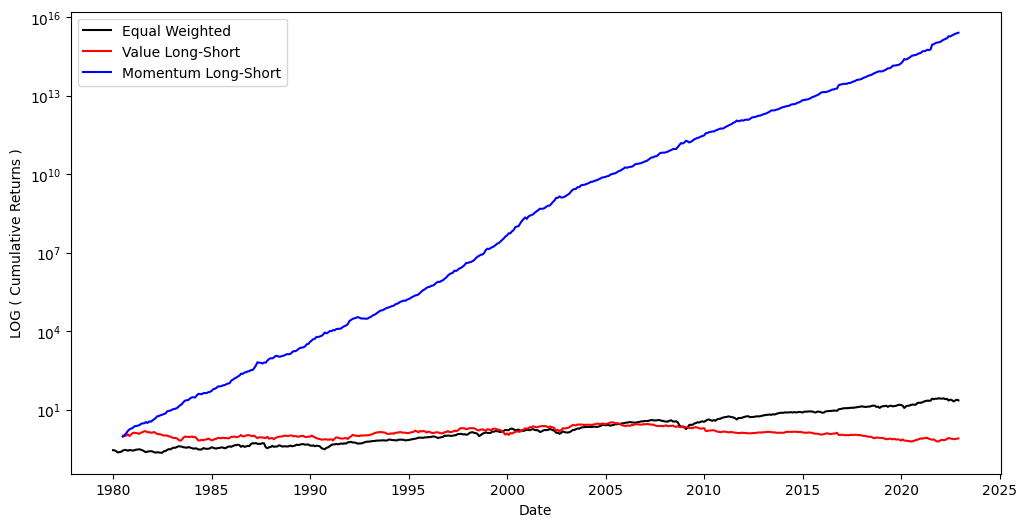

,mean_return,volatility,sharpe_ratio,skewness,kurtosis,max_drawdown
Equal_weighted,0.123306,0.203264,0.606629,-0.243811,2.403131,-0.545124
Value_long_short,0.015120,0.203724,0.074219,0.173295,1.148806,-0.815434
MoM_long_short,0.893770,0.241375,3.702825,1.159193,4.626824,-0.139417


In [8]:
# Calculate equal-weighted returns for each tercile portfolio
bm_tercile_returns = df_tic.groupby(['date', 'bm_tercile'])['monthly_returns'].mean().unstack()
mom_tercile_returns = df_tic.groupby(['date', 'mom_tercile'])['monthly_returns'].mean().unstack()

# Construct long-short portfolios
bm_tercile_returns['Value_long_short'] = bm_tercile_returns['Value_high'] - bm_tercile_returns['Value_low']
mom_tercile_returns['MoM_long_short'] = mom_tercile_returns['MoM_high'] - mom_tercile_returns['MoM_low']

tercile_returns = pd.concat([bm_tercile_returns['Value_long_short'],mom_tercile_returns['MoM_long_short']], axis=1)

# Backtest an equal-weighted portfolio investing in the 50 stocks
equal_weighted_returns = df_tic.groupby('date')['monthly_returns'].mean()
equal_weighted_cumulative = (1 + equal_weighted_returns).cumprod()

# Calculate the cumulative returns for each long-short portfolio
tercile_returns['Value_long_short'] = (1 + tercile_returns['Value_long_short']).cumprod()
tercile_returns['MoM_long_short'] = (1 + tercile_returns['MoM_long_short']).cumprod()

# Calculate annualized performance statistics
annualized_mean_return = df_tic.groupby(['bm_tercile', 'mom_tercile'])['monthly_returns'].mean() * 12
annualized_volatility = df_tic.groupby(['bm_tercile', 'mom_tercile'])['monthly_returns'].std() * np.sqrt(12)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(equal_weighted_returns.index, equal_weighted_cumulative, label='Equal Weighted', color = 'black')
plt.plot(tercile_returns.index, tercile_returns['Value_long_short'], label='Value Long-Short', color = 'r')
plt.plot(tercile_returns.index, tercile_returns['MoM_long_short'], label='Momentum Long-Short', color = 'b')
plt.xlabel('Date')
plt.ylabel('LOG ( Cumulative Returns )')
plt.yscale('log')
plt.legend()
plt.show()

# Annualized performance statistics
portfolios = {
    'Equal_weighted': equal_weighted_cumulative,
    'Value_long_short': tercile_returns['Value_long_short'],
    'MoM_long_short': tercile_returns['MoM_long_short']
}

stats_LS = pd.DataFrame(index=['mean_return', 'volatility', 'sharpe_ratio', 'skewness', 'kurtosis', 'max_drawdown'], columns=portfolios.keys())

for name, portfolio in portfolios.items():
    returns = portfolio.pct_change().dropna()
    avg_return = returns.mean() * 12
    volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = avg_return / volatility
    skewness_ = skew(returns)
    kurtosis_ = kurtosis(returns)
    drawdowns = (portfolio / portfolio.cummax()) - 1
    max_drawdown = drawdowns.min()
    stats_LS[name] = [avg_return, volatility, sharpe_ratio, skewness_, kurtosis_, max_drawdown]

stats_LS = stats_LS.T
display(stats_LS)

The MoM_long_short portfolio demonstrates superior performance with the highest mean return of 0.893770, outperforming the Equal_weighted portfolio at 0.123306 and the Value_long_short portfolio at 0.015120. In terms of risk, measured by volatility, the MoM_long_short portfolio also has the highest value at 0.241375, followed by the Value_long_short portfolio at 0.203724 and the Equal_weighted portfolio at 0.203264.

Examining the risk-adjusted return using the Sharpe ratio, the MoM_long_short portfolio again leads with a value of 3.702825, while the Equal_weighted portfolio has a Sharpe ratio of 0.606629 and the Value_long_short portfolio scores just 0.074219. This indicates that the MoM_long_short portfolio offers a better risk-reward trade-off.

In terms of return distribution, the MoM_long_short portfolio has the highest skewness at 1.159193, suggesting more frequent positive returns. The Value_long_short portfolio follows with a skewness of 0.173295, while the Equal_weighted portfolio has a negative skewness of -0.243811. The MoM_long_short portfolio also exhibits the highest kurtosis at 4.626824, indicating a higher probability of extreme returns, either positive or negative. The Equal_weighted portfolio has a kurtosis of 2.403131, and the Value_long_short portfolio has the lowest kurtosis at 1.148806.

When assessing the largest percentage loss from the highest to the lowest point in the investment portfolios, the Value_long_short portfolio experiences the worst maximum drawdown at -0.815434. The Equal_weighted portfolio follows with a maximum drawdown of -0.545124, while the MoM_long_short portfolio has the lowest maximum drawdown at -0.139417.

The plot of the cumulated returns shows that the Equal_weighted and Value_long_short portfolios have relatively flat, almost horizontal lines, indicating the low returns over time. In contrast, the Momentum_long_short portfolio appears to follow the y=log(x) function, as it is a straight line at a 45-degree angle, signifying the higher and increasing returns.

In summary, the MoM_long_short portfolio demonstrates the best performance, with the highest mean return, Sharpe ratio, skewness, and kurtosis, while also having the lowest maximum drawdown. This suggests a superior risk-reward trade-off and a greater likelihood of positive and extreme returns. The Equal_weighted and Value_long_short portfolios show less favorable performance metrics in comparison. Investors should consider their risk tolerance and investment objectives when evaluating these portfolios.

***

<h2 style='color:Blue'> 4. composite characteristics of momentum and value </h2>

Naturally, neither Value nor Momentum is the perfect predictor of returns. To combine the information that each characteristic contains, construct a composite characteristics. To this end, standardize in each month each characteristic to have a cross-sectional mean (standard deviation) of zero (one) and combine them into a single characteristic Sit defined as:

-- equation formula -- 

where the Mean and Standard deviation are taken over all stocks in the cross-section of month t. Now, sort the stocks on the composite characteristic and construct the long-short portfolio using tercile portfolios on this charateristics. Backtest this long-short portfolio. Plot cumulated returns and present annualized performance statistics for this long-short portfolio.

In [9]:
df_tic = df_tic.reset_index()

# Calculate the mean and standard deviation of BMit and Momit for each month
mean_bm = df_tic.groupby(df_tic['date'])['book_to_market'].mean()
std_bm = df_tic.groupby(df_tic['date'])['book_to_market'].std()
mean_mom = df_tic.groupby(df_tic['date'])['momentum_6m'].mean()
std_mom = df_tic.groupby(df_tic['date'])['momentum_6m'].std()

#Merge tables
df_tic = df_tic.merge(mean_bm, how='left', on='date').rename(columns={'book_to_market_y': 'mean_bm'})
df_tic = df_tic.merge(std_bm, how='left', on='date').rename(columns={'book_to_market': 'std_bm'})
df_tic = df_tic.merge(mean_mom, how='left', on='date').rename(columns={'momentum_6m_y': 'mean_mom'})
df_tic = df_tic.merge(std_mom, how='left', on='date').rename(columns={'momentum_6m': 'std_mom'})

# Standardize BMit and Momit
df_tic['std_bm_normalized'] = (df_tic['book_to_market_x'] - df_tic['mean_bm']) / df_tic['std_bm']
df_tic['std_mom_normalized'] = (df_tic['momentum_6m_x'] - df_tic['mean_mom']) / df_tic['std_mom']

#Calculate composite characteristic
df_tic['sit'] = df_tic['std_bm_normalized'] + df_tic['std_mom_normalized']
df_tic = df_tic.drop(['mean_bm','std_bm','mean_mom','std_mom','std_bm_normalized','std_mom_normalized'], axis=1)
df_tic = df_tic.rename(columns={'book_to_market_x': 'book_to_market'})
df_tic = df_tic.rename(columns={'momentum_6m_x': 'momentum_6m'})

# Create tercile portfolios based on Book-to-Market and Momentum
df_tic['sit_tercile'] = df_tic.groupby('date')['sit'].transform(create_equally_weighted_groups)

# Assign portfolio names
sit_labels = ['Sit_low', 'Sit_med', 'Sit_high']
df_tic['sit_tercile'] = df_tic['sit_tercile'].map(dict(enumerate(sit_labels)))


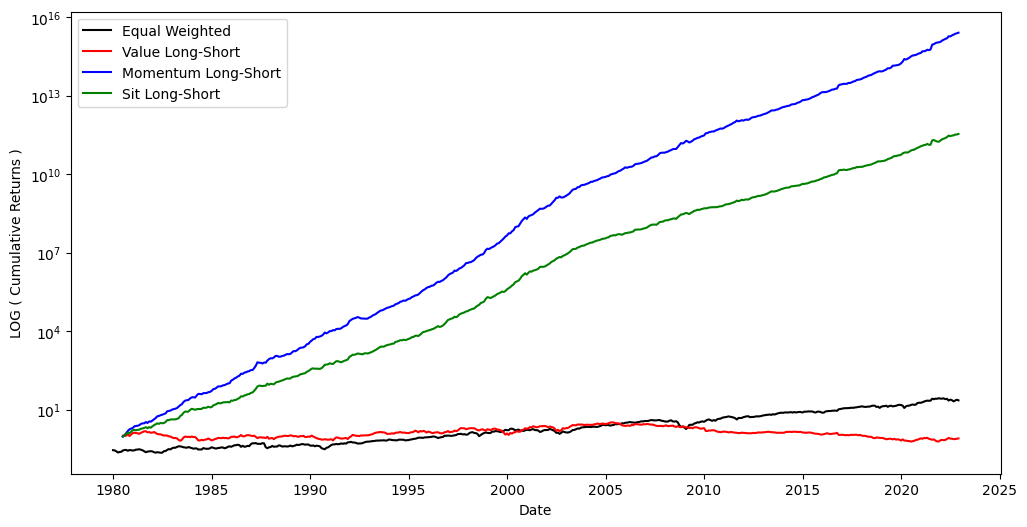

,mean_return,volatility,sharpe_ratio,skewness,kurtosis,max_drawdown
Equal_weighted,0.123306,0.203264,0.606629,-0.243811,2.403131,-0.545124
Value_long_short,0.015120,0.203724,0.074219,0.173295,1.148806,-0.815434
MoM_long_short,0.893770,0.241375,3.702825,1.159193,4.626824,-0.139417
Sit_long_short,0.665027,0.211972,3.137327,0.952488,3.832742,-0.137440


In [10]:
# Calculate equal-weighted returns for each tercile portfolio
sit_tercile_returns = df_tic.groupby(['date', 'sit_tercile'])['monthly_returns'].mean().unstack()

# Construct long-short portfolios
sit_tercile_returns['Sit_long_short'] = sit_tercile_returns['Sit_high'] - sit_tercile_returns['Sit_low']
tercile_returns = pd.concat([tercile_returns,sit_tercile_returns['Sit_long_short']], axis=1)

# Calculate the cumulative returns for each long-short portfolio
tercile_returns['Sit_long_short'] = (1 + tercile_returns['Sit_long_short']).cumprod()

# Calculate annualized performance statistics
annualized_mean_return = df_tic.groupby(['sit_tercile'])['monthly_returns'].mean() * 12
annualized_volatility = df_tic.groupby(['sit_tercile'])['monthly_returns'].std() * np.sqrt(12)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(equal_weighted_returns.index, equal_weighted_cumulative, label='Equal Weighted', color = 'black')
plt.plot(tercile_returns.index, tercile_returns['Value_long_short'], label='Value Long-Short', color = 'r')
plt.plot(tercile_returns.index, tercile_returns['MoM_long_short'], label='Momentum Long-Short', color = 'b')
plt.plot(tercile_returns.index, tercile_returns['Sit_long_short'], label='Sit Long-Short', color = 'g')
plt.xlabel('Date')
plt.ylabel('LOG ( Cumulative Returns )')
plt.yscale('log')
plt.legend()
plt.show()

# Annualized performance statistics
portfolios = {
    'Equal_weighted': equal_weighted_cumulative,
    'Value_long_short': tercile_returns['Value_long_short'],
    'MoM_long_short': tercile_returns['MoM_long_short'],
    'Sit_long_short': tercile_returns['Sit_long_short']
}

stats_LS = pd.DataFrame(index=['mean_return', 'volatility', 'sharpe_ratio', 'skewness', 'kurtosis', 'max_drawdown'], columns=portfolios.keys())

for name, portfolio in portfolios.items():
    returns = portfolio.pct_change().dropna()
    avg_return = returns.mean() * 12
    volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = avg_return / volatility
    skewness_ = skew(returns)
    kurtosis_ = kurtosis(returns)
    drawdowns = (portfolio / portfolio.cummax()) - 1
    max_drawdown = drawdowns.min()
    stats_LS[name] = [avg_return, volatility, sharpe_ratio, skewness_, kurtosis_, max_drawdown]

stats_LS = stats_LS.T
display(stats_LS)

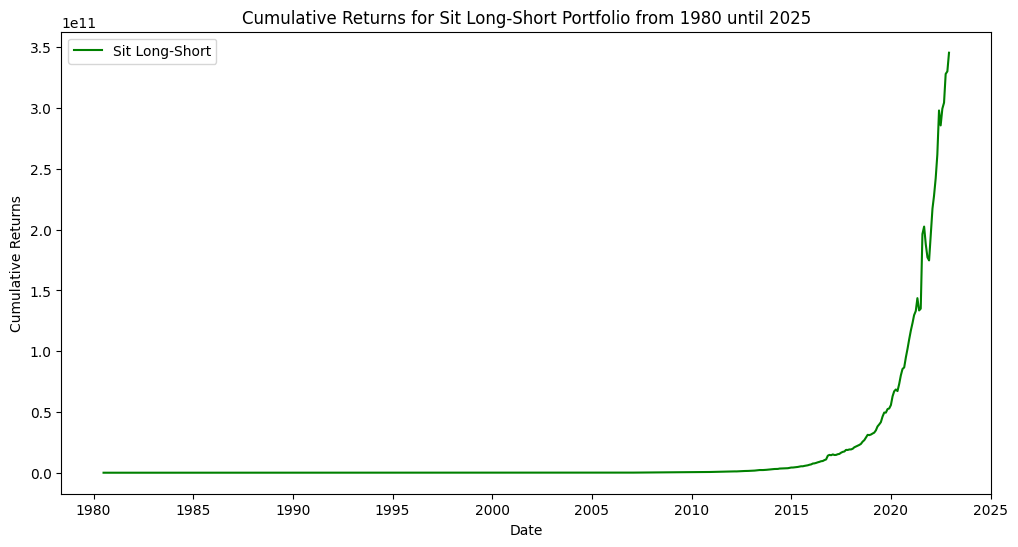

In [12]:
# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(tercile_returns.index, tercile_returns['Sit_long_short'], label='Sit Long-Short', color = 'g')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns for Sit Long-Short Portfolio from 1980 until 2025')
plt.legend()
plt.show()

Comparing the Sit_long_short portfolio with the other portfolios, it is evident that it performs better than both the Equal_weighted and Value_long_short portfolios but slightly underperforms the MoM_long_short portfolio in terms of mean return (0.665027 vs. 0.893770) and Sharpe ratio (3.137327 vs. 3.702825). The Sit_long_short portfolio has a lower volatility (0.211972 vs 0.241375) than the MoM_long_short portfolio, indicating a slightly lower risk.

The skewness of the Sit_long_short portfolio is positive (0.952488), suggesting a higher likelihood of positive returns, although it is lower than the MoM_long_short portfolio (1.159193). The kurtosis value for the Sit_long_short portfolio is 3.832742, which is lower than the MoM_long_short portfolio (4.626824), indicating a lower probability of extreme returns.

In terms of maximum drawdown, the Sit_long_short portfolio performs similarly to the MoM_long_short portfolio, with a value of -0.137440 compared to -0.139417. This indicates that the Sit_long_short portfolio's largest percentage loss from its peak to trough is only slightly better than that of the MoM_long_short portfolio.

The plot of cumulated returns for the Sit_long_short portfolio shows an increasing trend, parallel to the MoM_long_short portfolio, but slightly lower. This indicates that the Sit_long_short portfolio benefits from the combination of Value and Momentum characteristics, resulting in a favorable performance compared to the Equal_weighted and Value_long_short portfolios, although it does not surpass the MoM_long_short portfolio.

In summary, the Sit_long_short portfolio demonstrates an attractive risk-reward trade-off by combining Value and Momentum characteristics, leading to strong performance, although it does not outperform the MoM_long_short portfolio in most aspects.

***

<h2 style='color:Blue'> 5. 50% Value LS & 50% Momentum LS </h2>

Discuss how the performance of the strategy at the previous point compares to a mixed strategy that simply invests 50% in the the value long-short portfolio and %50 in the momentum long- short portfolio.

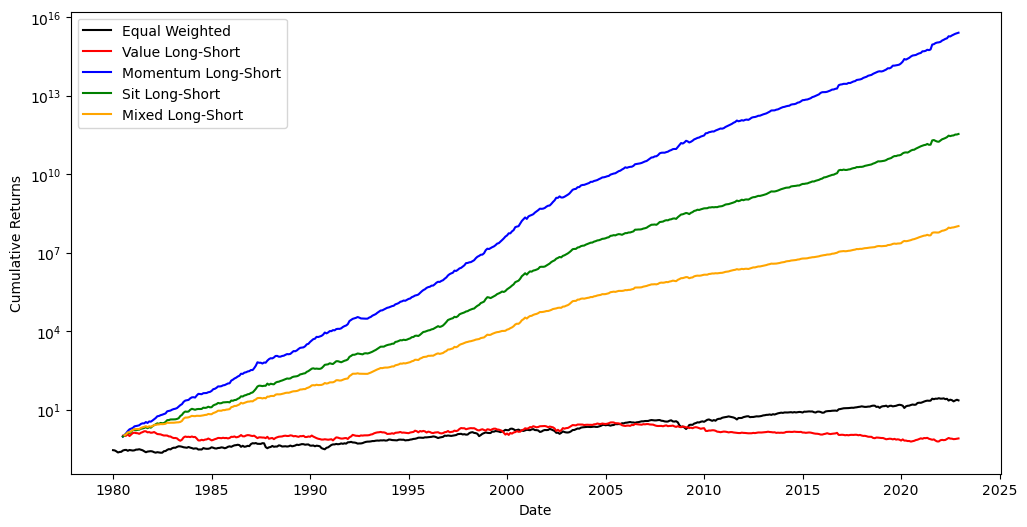

,mean_return,volatility,sharpe_ratio,skewness,kurtosis,max_drawdown
Equal_weighted,0.123306,0.203264,0.606629,-0.243811,2.403131,-0.545124
Value_long_short,0.015120,0.203724,0.074219,0.173295,1.148806,-0.815434
MoM_long_short,0.893770,0.241375,3.702825,1.159193,4.626824,-0.139417
Sit_long_short,0.665027,0.211972,3.137327,0.952488,3.832742,-0.137440
Mixed_long_short,0.454445,0.153626,2.958134,1.058975,2.708536,-0.096715


In [11]:
stats_LS
# ------
# Create the mixed long-short portfolio
tercile_returns['Mixed_long_short'] = 0.5 * tercile_returns['Value_long_short'].pct_change() + 0.5 * tercile_returns['MoM_long_short'].pct_change()

# Calculate cumulative returns
mixed_cumulative_returns = (1 + tercile_returns['Mixed_long_short']).cumprod()

# Calculate annualized performance statistics
mixed_stats = pd.Series(dtype=float)
mixed_stats['mean_return'] = tercile_returns['Mixed_long_short'].mean() * 12
mixed_stats['volatility'] = tercile_returns['Mixed_long_short'].std() * np.sqrt(12)
mixed_stats['sharpe_ratio'] = mixed_stats['mean_return'] / mixed_stats['volatility']
mixed_stats['skewness'] = tercile_returns['Mixed_long_short'].skew()
mixed_stats['kurtosis'] = tercile_returns['Mixed_long_short'].kurt()
mixed_stats['max_drawdown'] = (mixed_cumulative_returns / mixed_cumulative_returns.cummax() - 1).min()

mixed_stats = pd.DataFrame(mixed_stats).transpose()
mixed_stats.index = ['Mixed_long_short']

stats_LS = pd.concat([stats_LS, mixed_stats], axis=0)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(equal_weighted_returns.index, equal_weighted_cumulative, label='Equal Weighted', color = 'black')
plt.plot(tercile_returns.index, tercile_returns['Value_long_short'], label='Value Long-Short', color = 'r')
plt.plot(tercile_returns.index, tercile_returns['MoM_long_short'], label='Momentum Long-Short', color = 'b')
plt.plot(tercile_returns.index, tercile_returns['Sit_long_short'], label='Sit Long-Short', color = 'g')
plt.plot(tercile_returns.index, mixed_cumulative_returns, label='Mixed Long-Short', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.yscale('log')
plt.legend()
plt.show()

display(stats_LS)


The Mixed_long_short portfolio, which invests 50% in the Value_long_short portfolio and 50% in the MoM_long_short portfolio, offers a different approach to combining the Value and Momentum characteristics. Comparing the Mixed_long_short portfolio to the Sit_long_short portfolio, the former has a lower mean return (0.454445 vs. 0.665027) but also a lower volatility (0.153626 vs. 0.211972), suggesting a more conservative risk profile. The Sharpe ratio of the Mixed_long_short portfolio is slightly lower (2.958134) than that of the Sit_long_short portfolio (3.137327), indicating a marginally less favorable risk-reward trade-off.

The skewness of the Mixed_long_short portfolio is positive (1.058975) and higher than that of the Sit_long_short portfolio (0.952488), suggesting a higher likelihood of positive returns. The kurtosis value of the Mixed_long_short portfolio (2.708536) is lower than that of the Sit_long_short portfolio (3.832742), indicating a lower probability of extreme returns.

In terms of maximum drawdown, the Mixed_long_short portfolio outperforms the Sit_long_short portfolio with a value of -0.096715 compared to -0.137440, indicating a smaller maximum percentage loss from the peak to the trough.

The plot of cumulated returns for the Mixed_long_short portfolio shows an increasing trend parallel to the Sit_long_short and MoM_long_short portfolios, but it lies lower than the Sit_long_short portfolio.

In conclusion, the Mixed_long_short portfolio offers a more conservative approach to combining the Value and Momentum characteristics, with a lower mean return and volatility than the Sit_long_short portfolio. It has a slightly less favorable risk-reward trade-off, as indicated by its lower Sharpe ratio, but it also has a smaller maximum drawdown, which might be attractive for risk-averse investors. The choice between the Sit_long_short and Mixed_long_short portfolios depends on investors' risk tolerance and investment objectives.

***

<h2 style='color:Blue'> 6. FF5M model </h2>

Consider the long-short portfolios on Value, Momentum, the mixed charateristics and the equally weighted portfolio. Run performance analysis of this strategies against FF5M model. Comment on the alphas, the factor exposures and theR^2 of the factor regressions.

In [12]:
import pandas as pd
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import pandas_datareader.data as web

tercile_returns

,Value_long_short,MoM_long_short,Sit_long_short,Mixed_long_short
date,,,,
1980-01-01,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-08-01,0.787892,2.012153e+15,2.994956e+11,0.043355
2022-09-01,0.755633,2.156459e+15,3.044552e+11,0.015387
2022-10-01,0.765120,2.320989e+15,3.280984e+11,0.044425


In [13]:
# Get Fama-French 5 factors data
ff5f_m_2 = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
ff5f_m_2.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff5f_m_2.set_index('Date', inplace=True)

In [14]:
ff5f_m_2

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...
2022-11-30,0.0460,-0.0267,0.0138,0.0601,0.0311,0.0029
2022-12-31,-0.0641,-0.0016,0.0132,0.0009,0.0419,0.0033
2023-01-31,0.0665,0.0443,-0.0405,-0.0262,-0.0453,0.0035


In [15]:
import pandas as pd
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import pandas_datareader.data as web

# loading risk free rate data
rf = pd.read_csv('risk_free_rate.csv', index_col=0, parse_dates=True)

# Convert in dataframe
rf = pd.DataFrame(rf)

# Transform date column to datetime
rf['dateff'] =  pd.to_datetime(rf['dateff'], format='%Y-%m-%d')
rf['dateff'] = rf['dateff'].dt.to_period('M')

# Rename date column
rf.rename(columns={'dateff': 'date'}, inplace=True)

# reset index
rf.reset_index(inplace=True)

# rename rf to RF
rf.rename(columns={'rf': 'RF'}, inplace=True)

# set date as index
rf.set_index('date', inplace=True)


In [16]:
# Get Fama-French 5 factors data
ff5m_data = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start="1980-01-01")[0]
ff5m_data.rename(columns={'Mkt-RF': 'Mkt_RF'}, inplace=True)
ff5m_data.reset_index(inplace=True)
ff5m_data.rename(columns={'Date': 'date'}, inplace=True)
ff5m_data['date'] = ff5m_data['date'].dt.to_timestamp()
ff5m_data.set_index('date', inplace=True)

# Get Fama-French 5 factors data
#ff5f_m_2 = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
#ff5f_m_2.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
#ff5f_m_2.set_index('Date', inplace=True)

# Merge the long-short portfolio returns with the FF5M factor data
tercile_returns_2 = tercile_returns.reset_index()
tercile_returns_2['date'] =  pd.to_datetime(tercile_returns_2['date'], format='%Y-%m-%d')
tercile_returns_2['date'] = tercile_returns_2['date'].dt.to_period('M')
tercile_returns_2 = tercile_returns.merge(ff5m_data, on='date', how='inner')

# Columns to check for NaN values
columns_to_check = ['Value_long_short', 'MoM_long_short', 'Sit_long_short', 'Mixed_long_short']

# Filter rows with no NaN values in specific columns
tercile_returns_2 = tercile_returns_2.dropna(subset=columns_to_check)

display(tercile_returns_2)

,Value_long_short,MoM_long_short,Sit_long_short,Mixed_long_short,Mkt_RF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,
1980-08-01,1.000803,1.083846e+00,1.052224e+00,0.065776,1.80,4.25,-2.60,2.06,-0.86,0.64
1980-09-01,1.028573,1.275162e+00,1.189385e+00,0.102132,2.19,0.67,-4.59,1.91,-2.76,0.75
1980-10-01,1.160517,1.549378e+00,1.339088e+00,0.171661,1.06,2.33,-2.76,1.65,-1.15,0.95
1980-11-01,0.994136,1.792888e+00,1.277590e+00,0.006899,9.59,-3.31,-8.33,4.50,-5.66,0.96
1980-12-01,1.138767,1.901395e+00,1.462762e+00,0.103002,-4.52,-0.29,2.79,-1.29,1.24,1.31
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.787892,2.012153e+15,2.994956e+11,0.043355,-3.77,1.49,0.30,-4.78,1.29,0.19
2022-09-01,0.755633,2.156459e+15,3.044552e+11,0.015387,-9.35,-0.97,0.06,-1.51,-0.84,0.19
2022-10-01,0.765120,2.320989e+15,3.280984e+11,0.044425,7.83,1.86,8.05,3.07,6.52,0.23


In [17]:

# Calculate excess returns for each long-short portfolio
portfolios = ['Value_long_short', 'MoM_long_short', 'Sit_long_short', 'Mixed_long_short']
for p in portfolios:
    tercile_returns_2[f'{p}_excess'] = tercile_returns_2[p] - tercile_returns_2['RF']

# Initialize empty dictionaries to store the results
alphas_FF5 = {}
TE_FF5 = {}
IR_FF5 = {}
factor_exposures = {}
R2 = {}

# Perform the regression analysis for each long-short portfolio
regression_results = {}
for p in portfolios:
    # Set the dependent variable (excess returns) and independent variables (FF5M factors)
    Y = tercile_returns_2[f'{p}_excess']
    X = tercile_returns_2[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)

    # Run the regression
    model = sm.OLS(Y, X)
    model_fit = model.fit()

    # Store the regression results
    regression_results[p] = model_fit
    
    alpha = model_fit.params[0]
    t_error = model_fit.resid.std()
    ir = alpha / t_error

    alphas_FF5[p] = alpha
    TE_FF5[p] = t_error
    IR_FF5[p] = ir
    factor_exposures[p] = model_fit.params[1:]
    R2[p] = model_fit.rsquared

# Print the regression results
for p, model in regression_results.items():
    print(f'Regression Results for {p}:')
    print(model.summary())
    print('\n')

# Especially create a DataFrame with the alpha, TE, and IR and print it
results_df = pd.DataFrame({
    'Alpha_FF5': list(alphas_FF5.values()),
    'TE_FF5': list(TE_FF5.values()),
    'IR_FF5': list(IR_FF5.values())
}, index=portfolios)
print(results_df)

# Especially print and highlight Alphas, Factor Exposures, and R2
print("\nAlphas:")
print(pd.Series(alphas_FF5))
print("\nFactor Exposures:")
print(pd.DataFrame(factor_exposures).T)
print("\nR-squared:")
print(pd.Series(R2))

Regression Results for Value_long_short:
                               OLS Regression Results                              
Dep. Variable:     Value_long_short_excess   R-squared:                       0.008
Model:                                 OLS   Adj. R-squared:                 -0.002
Method:                      Least Squares   F-statistic:                    0.8065
Date:                     Tue, 09 May 2023   Prob (F-statistic):              0.545
Time:                             15:40:59   Log-Likelihood:                -571.99
No. Observations:                      509   AIC:                             1156.
Df Residuals:                          503   BIC:                             1181.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

Comment on the alphas, the factor exposures and the R2 of the factor regressions:


1. Value_long_short:
- Alpha: 1.1131, which indicates a significant positive outperformance relative to the FF5 model.
- Factor exposures: The portfolio has a positive exposure to SMB (0.0214) and HML (0.0101), but negative exposure to Mkt_RF (-0.0074), RMW (0.0009) and CMA (-0.0203). Market (Mkt_RF) -0.0074, Size (SMB) 0.0214, Value (HML) 0.0101, Profitability (RMW) 0.0009, and Investment (CMA) -0.0203. None of these factors are statistically significant except for SMB, which is significant at the 0.1 level.
- R-squared: 0.0079, which indicates that only 0.79% of the portfolio's return variance is explained by the FF5 model. This is a very low explanatory power. Adj. R-squared: -0.0021. The model explains only 0.79% of the variance in the Value_long_short excess returns.


2. MoM_long_short:
- Alpha: 6.477e+13, which indicates a significant positive outperformance relative to the FF5 model. Alpha: 6.477e+13, significant at the 0.001 level, indicating abnormal performance not explained by the factors.
- Factor exposures: The portfolio has a positive exposure to SMB (1.755e+12) and CMA (1.843e+13), but negative exposure to Mkt_RF (6.812e+11), HML (-1.227e+12), and RMW (6.931e+12). Market (Mkt_RF) 6.812e+11, Size (SMB) 1.755e+12, Value (HML) -1.227e+12, Profitability (RMW) 6.931e+12, and Investment (CMA) 1.843e+13. None of these factors are statistically significant.
- R-squared: 0.0163, which indicates that only 1.63% of the portfolio's return variance is explained by the FF5 model. This is also a very low explanatory power. Adj. R-squared: 0.007. The model explains only 1.6% of the variance in the MoM_long_short excess returns.

3. Sit_long_short:
- Alpha: 1.327e+10, which indicates a significant positive outperformance relative to the FF5 model. Alpha: 1.327e+10, significant at the 0.001 level, indicating abnormal performance not explained by the factors.
- Factor exposures: The portfolio has a positive exposure to Mkt_RF (2.047e+08), SMB (2.726e+08), and CMA (2.539e+09), but negative exposure to HML (-1.239e+08) and RMW (1.045e+09). Market (Mkt_RF) 2.047e+08, Size (SMB) 2.726e+08, Value (HML) -1.239e+08, Profitability (RMW) 1.045e+09, and Investment (CMA) 2.539e+09. None of these factors are statistically significant.
- R-squared: 0.0122, which indicates that only 1.22% of the portfolio's return variance is explained by the FF5 model. This is a very low explanatory power as well. Adj. R-squared: 0.002. The model explains only 1.2% of the variance in the Sit_long_short excess returns.

4. Mixed_long_short:
- Alpha: -0.2834, which indicates a significant negative underperformance relative to the FF5 model. Alpha: -0.2834, significant at the 0.001 level, indicating abnormal performance not explained by the factors.
- Factor exposures: The portfolio has a positive exposure to Mkt_RF (0.0024), SMB (0.0049), and RMW (0.0019), but negative exposure to HML (-0.0054) and Investments (CMA) (0.0063). None of these factors are statistically significant. Market (Mkt_RF) 0.0024, Size (SMB) 0.0049, Value (HML) -0.0054, Profitability (RMW) 0.0019, and Investment (CMA) 0.0063. None of these factors are statistically significant.
- R-squared: 0.0056, which indicates that only 0.56% of the portfolio's return variance is explained by the FF5 model. This is the lowest explanatory power among the four portfolios. Adj. R-squared: -0.004. The model explains only 0.6% of the variance in the Mixed_long_short excess returns.


The Fama-French 5-factor model does not explain much of the variance in the excess returns of the four portfolios. All portfolios have statistically significant alphas, indicating abnormal performance not explained by the factors. Among the factor exposures, only the Size (SMB) factor exposure for the Value_long_short portfolio is marginally significant, while other factor exposures are statistically insignificant. This suggests that these portfolios might have other sources of risk or return not captured by the Fama-French 5-factor model.

It is worth considering alternative factor models or additional factors that may better explain the performance of these portfolios. For example, adding momentum, liquidity, or macroeconomic factors might improve the explanatory power of the model. Additionally, examining the specific strategies or underlying assets within each portfolio could provide insights into unique sources of risk or return that are not captured by the Fama-French factors.

In conclusion, the Fama-French 5-factor model appears to have limited explanatory power for the excess returns of the four portfolios (Value_long_short, MoM_long_short, Sit_long_short, Mixed_long_short). All portfolios exhibit significant alphas, which suggests the presence of abnormal performance not accounted for by the factors in the model. Further research and analysis are required to identify the sources of this abnormal performance and to better understand the risk and return characteristics of these portfolios.

To Conclude, all four portfolios exhibit low R-squared values, indicating that the FF5 model has limited explanatory power in predicting their returns. The Value_long_short, MoM_long_short, and Sit_long_short portfolios have significant positive alphas, while the Mixed_long_short portfolio has a significant negative alpha.

In [18]:
for p, model in regression_results.items():
    print(f'Tracking error for {p}:')
    tracking_error = np.std((tercile_returns_2[f'{p}_excess']).values - model.params[1]*tercile_returns_2['Mkt_RF'].values - model.params[2]*tercile_returns_2['SMB'].values - model.params[3]*tercile_returns_2['HML'].values-  model.params[4]*tercile_returns_2['RMW'].values - model.params[5]*tercile_returns_2['CMA'].values)
    print(tracking_error)
    print(f'Information Ratio for {p}:')
    IR = model.params[0]/tracking_error
    print(IR)
    print('\n')

Tracking error for Value_long_short:
0.7443897946835394
Information Ratio for Value_long_short:
1.4953668604809287


Tracking error for MoM_long_short:
306279905430591.25
Information Ratio for MoM_long_short:
0.21148476923708945


Tracking error for Sit_long_short:
49349600199.74909
Information Ratio for Sit_long_short:
0.2689189231325761


Tracking error for Mixed_long_short:
0.2834010398848928
Information Ratio for Mixed_long_short:
-0.9999534216408136




<h2 style='color:Blue'> 7. Trading on long-only versus long-short tercile portfolios </h2>

Is the performance analysis (α) driven mostly by one of the two legs (long ot short)? Discuss
    the implications for trading on long-only versus long-short tercile portfolios.

To assess if the performance analysis is driven mostly by one of the two legs (long or short), you can calculate the separate alpha values for the long and short portfolios and compare them.

In [20]:
def calculate_alphas(name, df, col1, col2):
    # Merge the long-short portfolio returns with the FF5M factor data
    tercile_returns = df[[col1,col2]].reset_index()
    tercile_returns['date'] = pd.to_datetime(tercile_returns['date'], format='%Y-%m-%d')
    tercile_returns['date'] = tercile_returns['date'].dt.to_period('M')
    tercile_returns = df[[col1,col2]].merge(ff5m_data, on='date', how='inner')

    # Columns to check for NaN values
    columns_to_check = [col1,col2]

    # Filter rows with no NaN values in specific columns
    tercile_returns = tercile_returns.dropna(subset=columns_to_check)

    # Calculate alpha for the long portfolio
    long_portfolio = tercile_returns[col1]
    Y = long_portfolio - tercile_returns['RF']
    X = tercile_returns[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    model_fit = model.fit()
    long_alpha = model_fit.params[0]
    tracking_error_long = np.std((Y).values - model_fit.params[1]*tercile_returns['Mkt_RF'].values - model_fit.params[2]*tercile_returns['SMB'].values - model_fit.params[3]*tercile_returns['HML'].values - model_fit.params[4]*tercile_returns['RMW'].values - model_fit.params[5]*tercile_returns['CMA'].values)
    
    # Calculate alpha for the short portfolio
    short_portfolio = tercile_returns[col2]
    Y = short_portfolio - tercile_returns['RF']
    X = tercile_returns[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    model_fit = model.fit()
    short_alpha = model_fit.params[0]
    tracking_error_short = np.std((Y).values - model_fit.params[1]*tercile_returns['Mkt_RF'].values - model_fit.params[2]*tercile_returns['SMB'].values - model_fit.params[3]*tercile_returns['HML'].values - model_fit.params[4]*tercile_returns['RMW'].values - model_fit.params[5]*tercile_returns['CMA'].values)
    
    data = {'Portfolio': [f'{name}: Long', f'{name}: Short'], 
            'Alpha': [long_alpha, short_alpha], 
            'Tracking Error': [tracking_error_long, tracking_error_short], 
            'Information Ratio': [long_alpha/tracking_error_long, short_alpha/tracking_error_short]}
    
    df_result = pd.DataFrame(data=data)
    df_result = df_result.set_index('Portfolio')
    
    return df_result


df_values = calculate_alphas("Value", bm_tercile_returns,"Value_high","Value_low")
df_mom = calculate_alphas("MoM", mom_tercile_returns,'MoM_high','MoM_low')
df_sit = calculate_alphas("Sit", sit_tercile_returns,'Sit_high','Sit_low')

display(pd.concat([df_values, df_mom, df_sit]))


,Alpha,Tracking Error,Information Ratio
Portfolio,,,
Value: Long,-0.319175,0.287186,-1.111389
Value: Short,-0.320173,0.289310,-1.106679
MoM: Long,-0.284463,0.287092,-0.990840
MoM: Short,-0.359244,0.295088,-1.217412
Sit: Long,-0.294327,0.288393,-1.020576
Sit: Short,-0.349560,0.290932,-1.201521


Looking at the alpha values for each long and short portfolio in to determine which leg is driving the performance analysis. If the alpha values for the long leg are significantly higher or lower than the alpha values for the short leg across all portfolios, then it suggests that the performance analysis (α) is driven mostly by one of the two legs. For all the portfolios we see that the alphas are not significantly different from one another, which suggests that the performance analysis is not being driven predominantly by one of the two legs. This implies that both the long and short legs of the portfolio are contributing equally to the portfolio's overall performance. 

Calculating the tracking error (TE) and information ratio (IR) can help in understanding the relative contribution of the long and short legs to the overall alpha (α) of the long-short portfolios. If the tracking error is higher for the long leg compared to the short leg, it suggests that the alpha is driven mostly by the long leg, and vice versa. Since the tracking error is similar for both legs, then both the long and short legs are contributing equally to the overall alpha. Similarly, if the information ratio is higher for the long leg compared to the short leg, it suggests that the long leg is generating more risk-adjusted returns than the short leg, and vice versa.

In terms of implications for trading on long-only versus long-short tercile portfolios, the results of the performance analysis can help in deciding which strategy to pursue. If the alpha is mostly driven by the long leg, it may be more beneficial to invest in long-only portfolios. On the other hand, if both the long and short legs are contributing to the alpha, it may be more appropriate to trade on long-short portfolios.

Additionally we can see that all the alpha values are all negative, it suggests that there is a market-neutral strategy which taking long and short positions in the market such that the returns generated from the long and short legs are offsetting each other, resulting in a net positive alpha for the long-short portfolio.  

When the individual long and short alpha values are negative, it means that the excess returns generated by those legs of the portfolio are lower than what would be expected based on their exposure to systematic risk factors. In other words, the portfolio is underperforming relative to the systematic factors it is exposed to. However, when the long-short alpha value is positive, it means that the excess returns generated by the long-short portfolio as a whole are higher than what would be expected based on its exposure to systematic risk factors. 

On the other hand, long-short portfolios have lower market exposure than long-only portfolios because they take both long and short positions in the market. This means that the returns generated by long-short portfolios are less closely tied to the performance of the broader market and are more dependent on the manager's skill in selecting long and short positions. 

<h2 style='color:Blue'> 8. Neutralising long-short Value portfolio </h2>

Discuss theoretically how to modify the construction of the long-short Value portfolio in order
    to make it market neutral (i.e. uncorrelated with returns on the market portfolio) over a rolling
    widow of 3 years.


A long-short Value portfolio is constructed by selecting stocks that are undervalued by the market and buying them (going long) while simultaneously selling (going short) stocks that are overvalued by the market. The portfolio aims to capture the return spread between the two sets of stocks while being market sensitive, i.e., the portfolio's returns are correlated with the returns on the overall market.

To make the portfolio market-neutral over a rolling window of 3 years, the following steps can be taken:

1. Estimate the beta of each stock: Beta is a measure of a stock's sensitivity to the market. Stocks with a beta of 1 have returns that move in line with the market, while those with a beta of less than 1 have returns that move less than the market, and those with a beta of more than 1 have returns that move more than the market. By estimating the beta of each stock, we can select a set of stocks whose returns are uncorrelated with the market. This can be done as before, by regressing the stocks returns against the returns of the market (CAPM), or teh FF5 model as described. To incorporate the rolling window, we use time $ t $, which represents the monthly data of the last three years, and the slope of the regression line gives the estimate for $\beta$ for each stock.

$$ R_{brka,t} - R_{f,t} = \alpha - \beta(R_{mkt,t} + R_{f,t} + R_{hml,t} + R_{smb,t}+ R_{rmw,t}+ R_{cma,t}) + \varepsilon_t $$

2. Select long and short positions based on beta: Once the beta of each stock has been estimated, we can select long and short positions such that the overall beta of the portfolio is zero. For instance, we can select an equal number of stocks with beta greater than 1 and those with beta less than 1, such that the overall beta of the long and short positions offset each other.

3. Adjust position sizes: After selecting the long and short positions, the next step is to adjust the position sizes such that the overall portfolio is market-neutral. We can do this by computing the dollar value of each long and short position and making sure that they sum up to zero. This ensures that the portfolio has a zero beta, and is uncorrelated with the market.

The portfolios $\beta$ can be calculated as:
$$\beta_p = ∑_{i=1}^n w_i \beta_i $$
To ensure market neutrality, $\beta_p$ should be equal to 0, as well as the sum of the weights of the long and short positions should equal 1. 
$$∑_{i=1}^n w_i^L = 1$$
$$∑_{i=1}^n w_i^S = -1$$
Where $w_i^L$ is the weight on a portfolio $i$, which has a long position $L$, and $w_i^S$ is the weight on a portfolio $i$, which has a short position $S$,so ths portfolios beta $\beta_p$ can be redefined as:
$$∑_{i=1}^n w_i^L \beta_i^L  + ∑_{i=1}^n w_i^S \beta_i^S = \beta_p - \beta_p = 0$$

$$∑_{i=1}^n (w_i^S - w_i^L) β_i = 0$$

Since we want the portfolio's overall beta to be zero, we can solve for the weights of the long and short positions as follows:

$$w_i^L - w_i^S = \frac{ -β_i }{∑_{j=1}^n β_j}$$

Substituting this into the first equation above, we get:
$$W_i^L = \frac{ β_i^L }{∑_{j=1}^n β_j}$$
$$W_i^S = - \frac{ -|β_i^S| }{∑_{j=1}^n |β_j|}$$

This shows that the weight of each long position can be computed as the beta of that stock divided by the sum of the betas of all the long positions in the portfolio and the weight of each short position can be computed as the negative beta of that stock divided by the sum of the absolute values of the betas of all the short positions in the portfolio.
The overall weights on the long and short positions can simply be calculated as: 
$$w^L = ∑_{i=1}^n w_i^L$$
$$w^S = ∑_{i=1}^n w_i^S$$

To compute the dollar value of each long and short position, we need to multiply the weight of each position by the total dollar value of the portfolio. 

4. Rebalance the portfolio: To maintain market neutrality over a rolling window of 3 years, the portfolio needs to be rebalanced regularly. This involves adjusting the long and short positions based on changes in the beta of each stock. If a stock's beta changes such that it is no longer contributing to the market neutrality of the portfolio, its position size needs to be adjusted accordingly.